# AIMS ocean temperature dataset
Authors: Leo Ghignone, Denisse Fierro Arcos  
  
This notebook demonstrates direct access to the [AIMS Temperature Logger Monitoring Program](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e) dataset in the RIMReP `geoparquet` collection. This dataset includes sea temperature data from 1980 for tropical and subtropical coral reefs around Australia, and it includes sites within the Great Barrier Reef.   
  
The `geoparquet` collection is a compilation of datasets that have been converted to the Apache `parquet` format. This format is designed for efficient storage and retrieval of tabular data. The `geoparquet` collection is stored on the RIMReP S3 bucket and is accessible to all users.  
  
The workflow in this notebook is as follows:
- Inspect dataset metadata
- Subset the dataset to include sites within the Great Barrier Reef (GBR)
- Aggregate temperature data per site
- Create a map with the location of all sites where GBR temperature loggers were deployed

## Loading libraries

In [1]:
# Accessing S3 bucket
from pyarrow import parquet as pq
# Manipulating dataframes
import pandas as pd
# Load and manipulate geospatial data
import dask_geopandas
# Plotting
import matplotlib.pyplot as plt
# Mapping
import cartopy.crs as ccrs
import cartopy.feature as cf

## Inspecting metadata
The AIMS Temperature dataset contains over 150 million records. We will use its metadata to check the structure of the dataset and to determine the best way to access the data.

In [2]:
#Connecting to metadata file
md = pq.read_metadata(f"s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/_metadata")
#Checking contents
md

  created_by: parquet-cpp-arrow version 10.0.1
  num_columns: 23
  num_rows: 150663521
  num_row_groups: 50
  format_version: 2.6
  serialized_size: 155051

The metadata is telling us that the AIMS temperature dataset contains 23 columns and over 150 million rows, and it is made up of 50 different files.  
  
We can check the structure of the data by calling its `schema` attribute. This will return a list containing the name of the column and its data type.

In [3]:
md.schema

required group field_id=-1 schema {
  optional int64 field_id=-1 fid;
  optional int64 field_id=-1 deployment_id;
  optional binary field_id=-1 site (String);
  optional int64 field_id=-1 site_id;
  optional binary field_id=-1 subsite (String);
  optional int64 field_id=-1 subsite_id;
  optional int64 field_id=-1 from_date (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional int64 field_id=-1 thru_date (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional double field_id=-1 depth;
  optional binary field_id=-1 parameter (String);
  optional binary field_id=-1 instrument_type (String);
  optional binary field_id=-1 serial_num (String);
  optional double field_id=-1 lat;
  optional double field_id=-1 lon;
  optional binary field_id=-1 gbrmpa_reef_id (String);
  optional binary field_id=-1 metadata_uuid (String);
  optional double fie

The `schema` tells us that the dataset contains 23 columns, which matches the information we got from the metadata. It also tells us that the data types are either `string` or `double`.  
  
We can also obtain more details about a specific column, by calling the `column` method and passing the name of the column as an argument as shown below.

In [4]:
md.schema.column(19)

<ParquetColumnSchema>
  name: qc_val
  path: qc_val
  max_definition_level: 1
  max_repetition_level: 0
  physical_type: DOUBLE
  logical_type: None
  converted_type (legacy): NONE

If we refer to the original site for the [AIMS Temperature Logger Monitoring Program](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e), we can see that the `qc_val` column refers to the quality controlled temperature obtained from the loggers deployed as part of this program.

## Connecting to S3 parquet directory
We will connect to the S3 bucket containing the AIMS Temperature dataset using the `pyarrow` library. We will only keep sites that have been deployed in the Great Barrier Reef Marine Protected Area (GBRMPA), so we will provide a `filter` that contains the minimum and maximum coordinates (i.e., `lat` and `lon`) of a bounding box around the Great Barrier Reef Marine Protected Area.

As we saw above, this dataset includes 23 columns, but we will only select a few that contain information that is interesting to us:
- `site`: name of site where temperature logger was deployed,
- `lat`: latitude of the logger deployment site,
- `lon`: longitude of the logger deployment site,
- `time`: date and time when loggers recorded temperature data,
- `qc_val`: quality controlled temperature data
  
The following code chunk may take a few minutes to run, as it is loading over 150 million records.

In [13]:
# Creating maximum and minimum coordinates for bounding box around the GBRMPA
filter = [('lon', '>=', 140.5),
          ('lat', '>=', -28.5),
          ('lon', '<=', 156.0),
          ('lat', '<=', -6.5)]

# Connecting to the S3 bucket where the AIMS temperature data is stored
dask_geo_df = dask_geopandas.read_parquet("s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
                                          #Applying initial bounding box filter
                                          filters = [filter], 
                                          #Specifying which columns to read
                                          columns = ['site', 'time', 'qc_val', 'lat', 'lon'],
                                          #Specifying the column to be used as index
                                          index = 'fid',
                                          #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                          storage_options = {"anon": True}) 

# Transforming to pandas dataframe
df = dask_geo_df.compute()

#Checking the contents of the dataframe - First five rows
df.head()

,site,time,qc_val,lat,lon
fid,,,,,
149842221,Karumba,2002-12-10 02:00:00+00:00,31.043,-17.4935,140.8302
149696096,Karumba,2003-07-17 18:30:00+00:00,20.547,-17.4935,140.8302
149696097,Karumba,2003-07-17 19:00:00+00:00,20.567,-17.4935,140.8302
149696098,Karumba,2003-07-17 19:30:00+00:00,20.629,-17.4935,140.8302
149696099,Karumba,2003-07-17 20:00:00+00:00,20.649,-17.4935,140.8302


You can see above that the `site` is repeated multiple times. This is because the temperature loggers were deployed on multiple occassions at the same site. If we print more rows, you will also see that the coordinates for a particular site vary slightly. This is because the temperature loggers were not deployed at the exact same location each time, but they were all deployed near each other.  
    
Next, we will calculate the mean deployment coordinate, mean temperature, and total number of temperature records for each site. We will use the `groupby` method to group the data by `site_id` and then we will use the `agg` method to perform our calculations.  
  
Note the use of `compute()` at the end of our code. This will trigger our calculations and load the results as a data frame into memory.

In [12]:
#Grouping our dataframe by site_id and aggregating the lat and lon columns by mean and the site_id column by count
counts = df.groupby('site').agg(
    #Calculating mean temperature
    tempMean = pd.NamedAgg(column = 'qc_val', aggfunc = 'mean'),
    #Calculating mean lat and lon
    latMean = pd.NamedAgg(column = 'lat', aggfunc = 'mean'),
    lonMean = pd.NamedAgg(column = 'lon', aggfunc = 'mean'),
    # #Calculating range of time when data was collected
    dateMin = pd.NamedAgg(column = 'time', aggfunc = 'min'),
    dateMax = pd.NamedAgg(column = 'time', aggfunc = 'max'), 
    #Calculating the number of rows (i.e., deployments) per site_id
    number = pd.NamedAgg(column = 'site', aggfunc = 'count'))

#Checking the contents of the dataframe - First five rows
counts.head()

,tempMean,latMean,lonMean,dateMin,dateMax,number
site,,,,,,
19-131 Reef,25.747975,-19.766148,149.378946,2011-03-12 14:06:51+00:00,2021-02-09 13:50:00+00:00,721871
19-138 Reef,25.757545,-19.805137,149.426347,2011-03-14 14:03:50+00:00,2022-01-05 13:50:00+00:00,929087
19-159 Reef,25.929941,-19.663895,149.915001,2011-03-20 14:08:10+00:00,2017-02-17 13:50:00+00:00,324720
20-104 Reef,25.845430,-20.028918,149.694016,2015-01-31 14:00:00+00:00,2021-02-13 13:50:00+00:00,526896
20-344 Reef,25.206312,-20.771892,150.891808,2006-09-05 14:00:00+00:00,2011-10-05 13:51:48+00:00,141552


## Mapping sites
From the summary table we created in the previous step, we will make a map with the location of all deployment sites within the GBRMPA bounding box. We will change the size of the markers based on the number of temperature records collected at each site (`number` column).

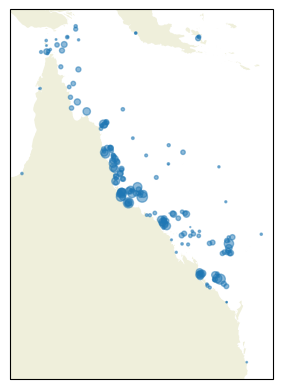

In [15]:
#Initiliasing the figure
fig = plt.figure()

#Adding a plot to the figure and assigning projection
ax = plt.axes(projection = ccrs.PlateCarree())

#Plotting the data using a scatter plot
ax.scatter(x = counts.lonMean, y = counts.latMean, s = counts.number/50000, alpha = 0.5)

#Adding a basemap of land areas
ax.add_feature(cf.LAND)

We have successfully plotted the location of the AIMS temperature loggers within the GBRMPA bounding box. We can see that the number of temperature records per logger is not the same throughout the GBRMPA. The largest number of records are for loggers located near the coast.